<a href="https://colab.research.google.com/github/Adesanza/dataline-stutern/blob/master/DataScience/Intertrack_Restaurant_Weekly_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restaurant Weekly Sales Prediction

## Abstract

Business thrive on decisons that are favourable. They even thrive more based on informed decision. Some of these decisions are better influenced by taking into consideration outcomes of actual historical data or activites that have happened in that line of business. 
This project focus on obtaining relevant data of a restaurant and transforming this data to provide insightful information and decision for better planning which is geared towards increased profit and better outcome.

## Introduction

This project focus on three main highlights. 
1. Data Engineering: This is essential as data are mostly presented in an unfriendly manner. Cleaning, removing outliers, properly categorizing to reduce wide data points and replacing missing data with the best method. This aspect is very crucial and is a huge determinant on how our model performs and acts. 

2. Data Visualization: Data is best observed by plotting them against other determinants. This gives a better understanding of how the data are represented. It also assist in removing data that do not contribute meaningfully to the targeted variable. Visualizing data can also help in pointing out outliers and misrepresented data points. It can help in reducing the biasness of data. 

3. Model development: This part is very crucial in this project since the aim is to ensure that users are able to tune their imputs and realize their expected outcome. Catboost model will be employed for the purpose of this project. It is fast and It provides a gradient boosting framework which attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm. 

## Data Engineering

As seen below, Numpy is a very fast library built on C# dependecies. It process data in form of Array and assist with computational abilities. Pandas is another crucial library for this project. It shapes and enables the manipulation of data in all forms. It also assist in presenting data in a readable format. 
Matplotlin and Seaborn are two crucial libraries that assists in visualizing data in all forms. Count, Bar graphs, line plot are all classes employed in the libraries to visuallly observe the data. 

**Importing Necessary Libraries**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style='darkgrid')
import joblib

## Load Data

In [ ]:
data = pd.read_csv('train_data_cleaned.csv')
#Data preview
data.head(5)

In [ ]:
table = pd.DataFrame({"Column" : list(data.isnull().sum().index),
                      "Null Values" : data.isnull().sum().values,
                      "Unique Values": [len(data[x].unique()) for x in data.columns],
                      "Dtype" : data.dtypes.values
                      })

In [ ]:
#Getting insight on missing values, data type and unique values
table

,Column,Null Values,Unique Values,Dtype
0,year_week,0,96,int64
1,recipe_id,0,1931,int64
2,recipe_name,0,931,object
3,product_type,0,4,object
4,calories,6,393,float64
5,carbs,47,406,float64
6,cooking_time,291,6,object
7,cuisine,833,28,object
8,description,4,981,object
9,difficulty,9,2,object


In [ ]:
#Removing columns with numerous unique values and no valid contribution to the target variable.
strpCol = ['year_week', 'recipe_id','recipe_name','cooking_tip', 'description', 'is_classic', 'course_type', 'difficulty', 'dish_types', 'seasons', 'carbs_content', 'percentage_of_local_ingredients', 'protein_cuts', 'meta_tags', 'course_type']
FullTable = data[[x for x in data.columns if x not in strpCol]]

In [ ]:
FullTable

,product_type,calories,carbs,cooking_time,cuisine,dish_type,heat_level,fat,number_of_ingredients_per_recipe,preferences,protein_types,proteins,sales
0,2 person,687.0,99.2,time_level_4,asian,fish,optional_heat,18.6,7,shellfish,shellfish,29.5,3567
1,2 person,779.0,81.3,time_level_4,new_american,veggie,no_heat,38.5,5,no_protein,no_protein,30.0,2532
2,z_amazon,642.0,92.8,NaN,NaN,veggie,NaN,25.6,10,NaN,NaN,16.2,6
3,family,620.0,93.2,time_level_4,asian,fish,optional_heat,13.7,7,shellfish,shellfish,28.7,642
4,family,610.0,67.0,time_level_4,new_american,meat,no_heat,20.0,7,poultry,poultry,36.0,1492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2 person,860.0,50.0,time_level_5,italian,veggie,no_heat,62.0,6,dairy,dairy,30.0,2015
2935,family,760.0,46.0,time_level_5,italian,veggie,no_heat,54.0,6,dairy,dairy,25.0,374
2936,2 person,960.0,104.0,time_level_4,thai,meat,no_heat,37.0,9,"fish,poultry","fish,poultry",56.0,1472
2937,2 person,760.0,51.0,time_level_5,new_american,meat,no_heat,42.0,8,"pork,poultry","pork,poultry",43.0,1134


In [ ]:
#Stripping out prefences. As same data value as protein types.
FullTable.drop('preferences', 1, inplace=True )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
FullTable.describe(include='all')

,product_type,calories,carbs,cooking_time,cuisine,dish_type,heat_level,fat,number_of_ingredients_per_recipe,protein_types,proteins,sales
count,2939,2933.000000,2892.000000,2648,2106,2521,2223,2892.000000,2939.000000,2238,2892.000000,2939.000000
unique,4,NaN,NaN,5,27,4,4,NaN,NaN,34,NaN,NaN
top,2 person,NaN,NaN,time_level_4,new_american,meat,no_heat,NaN,NaN,poultry,NaN,NaN
freq,1339,NaN,NaN,1359,897,1411,1874,NaN,NaN,446,NaN,NaN
mean,NaN,726.766792,64.969046,NaN,NaN,NaN,NaN,38.055595,7.046274,NaN,34.841110,2665.353862
std,NaN,169.665883,31.024875,NaN,NaN,NaN,NaN,28.815285,1.825963,NaN,12.763028,4765.205485
min,NaN,0.000000,3.000000,NaN,NaN,NaN,NaN,5.000000,0.000000,NaN,1.500000,3.000000
25%,NaN,616.000000,46.000000,NaN,NaN,NaN,NaN,27.175000,6.000000,NaN,26.000000,263.000000
50%,NaN,720.000000,63.500000,NaN,NaN,NaN,NaN,36.000000,7.000000,NaN,35.000000,829.000000
75%,NaN,834.000000,83.600000,NaN,NaN,NaN,NaN,45.000000,9.000000,NaN,43.600000,2315.500000


In [ ]:
#Filling missing values by method of mean and mode. 
def errorReplacer(table):
  '''
  table represent dataframe.
  Function identifies data type, check for the missing values and reccommends suitable method for replacing missing values.
  Mean for int or float datatype and mode for categorical data type. 
  '''
  df = table
  x = pd.DataFrame(df.isnull().sum())
  x = x[x[0] > 0]

  for i in x.index:
      if df[i].dtypes == 'float':
          mean = df[i].mean()
          df[i].replace(np.nan, mean, inplace = True)
          if df[i].dtypes == 'int':
              df[i] = df[i].astype(int)
          elif df[i].dtypes == 'float':
              pass
      elif df[i].dtypes == 'object':
          mode = df[i].mode()
          df[i] = df[i].replace({np.nan : mode.values})

In [ ]:
errorReplacer(FullTable)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Creating a list containing name of columns of categorical objects.
categoricalCols = [x for x in FullTable.columns if FullTable[x].dtypes == 'object']
TargetVar = ['sales']
numericalCols =  [x for x in FullTable.columns if x not in categoricalCols + TargetVar]

In [ ]:
CleanedTab = pd.DataFrame({"Column" : list(FullTable.isnull().sum().index),
                      "Null Values" : FullTable.isnull().sum().values,
                      "Unique Values": [len(FullTable[x].unique()) for x in FullTable.columns],
                      "Dtype" : FullTable.dtypes.values
                      })

In [ ]:
CleanedTab

,Column,Null Values,Unique Values,Dtype
0,product_type,0,4,object
1,calories,0,393,float64
2,carbs,0,406,float64
3,cooking_time,0,5,object
4,cuisine,0,27,object
5,dish_type,0,4,object
6,heat_level,0,4,object
7,fat,0,314,float64
8,number_of_ingredients_per_recipe,0,12,int64
9,protein_types,0,34,object


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


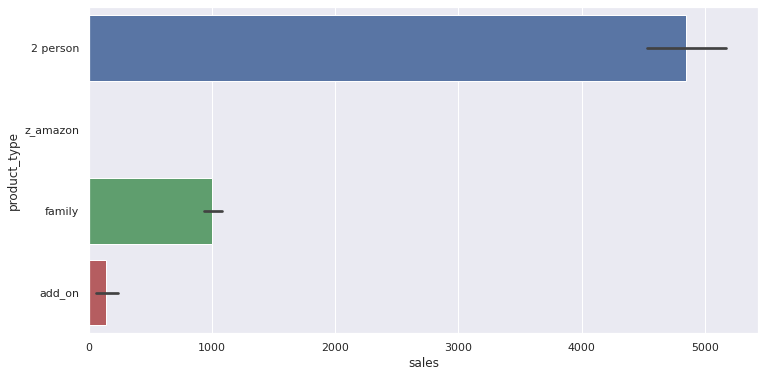

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


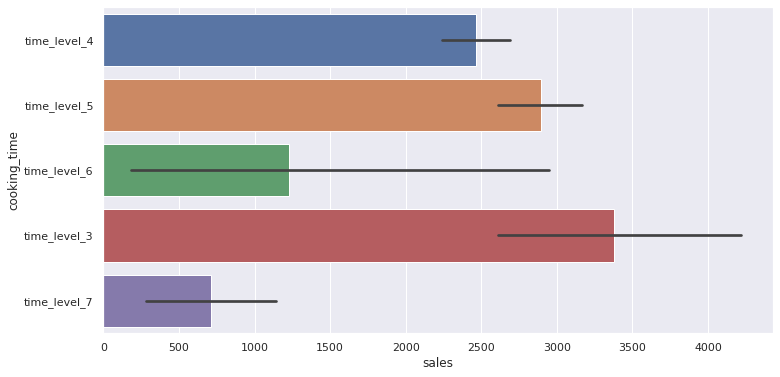

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


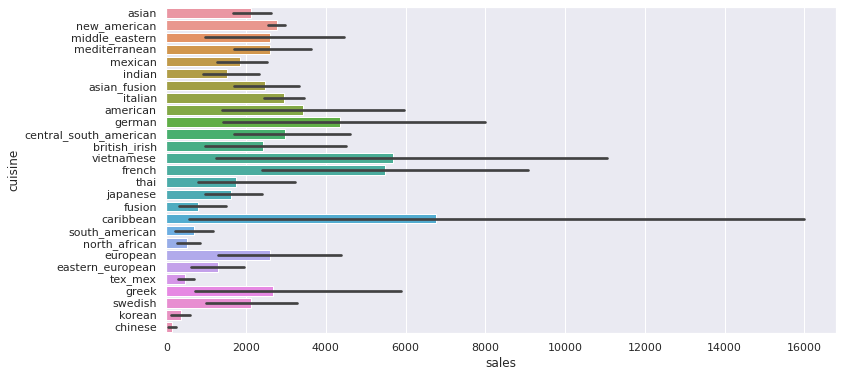

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


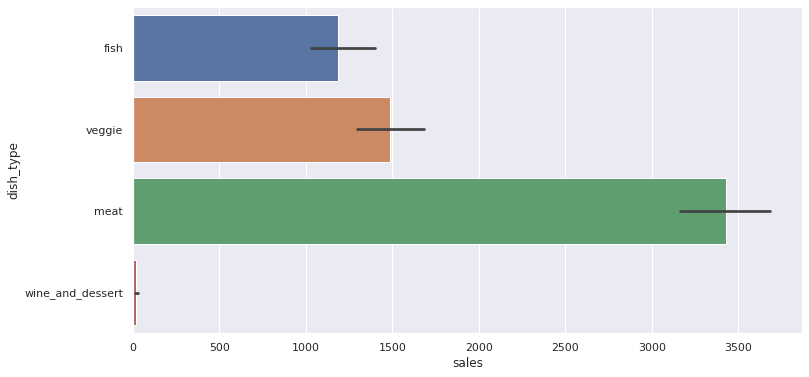

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


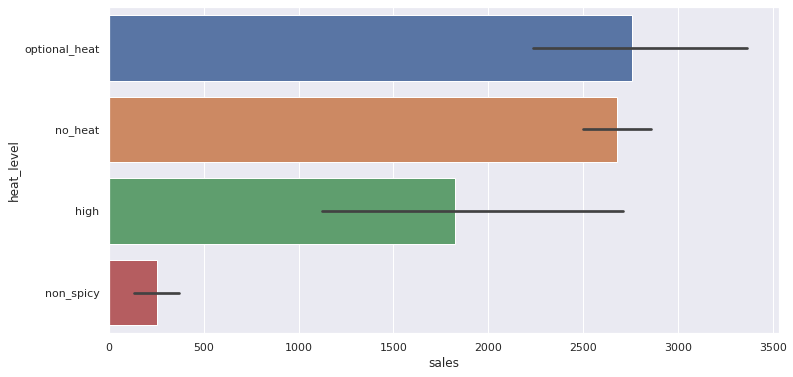

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


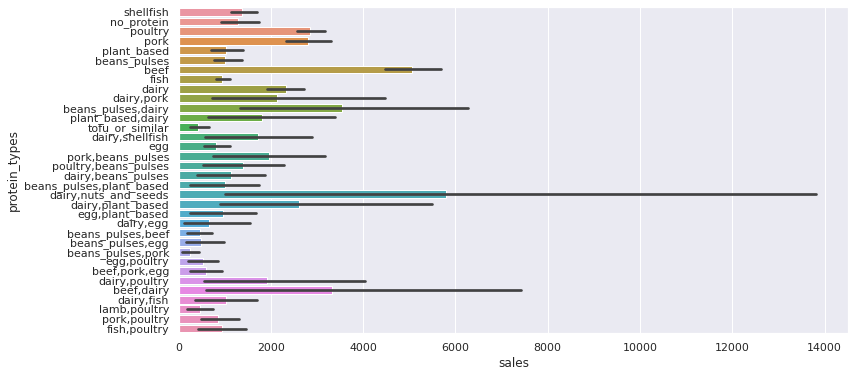

In [ ]:
# This function plots the varation of features as against the sales return using the total sum value
#Can give us better insights on the powerful deciding features on the the possibility of high sales return.
def barPlot(column):
  '''
  column takes the value of the current column feature which is used to plot against the sales column.
  '''
  fig = plt.figure(figsize = (12,6))
  sns.barplot( 'sales', column, data=FullTable)
  plt.show()

for i in categoricalCols:
  barPlot(i)

In [ ]:
#Grouping of simmilar products in protein types column
def ProCut(x):
  if x == 'shellfish' or x == 'fish' or x == 'tofu or similar':
    return 'fish'
  elif x == 'poultry' or x == 'egg' or x == 'dairy,egg' or x == 'beans_pulses,egg' or x == 'egg,poultry' or x == 'beef,pork,egg' or x == 'fish,poultry':
    return 'poultry products'
  elif x == 'plant_based' or x == 'beans_pulses' or x == 'beans_pulses,dairy' or x == 'plant_based,dairy' or x == 'pork,beans_pulses' or x == 'poultry,beans_pulses' or x == 'dairy,beans_pulses' or x == 'beans_pulses,plant_based' or x == 'dairy,nuts_and_seeds' or x == 'dairy,plant_based' or x == 'egg,plant_based' or x == 'beans_pulses,egg' or x == 'beans_pulses,pork':
    return 'plant products'
  elif x == 'pork' or x =='beef' or x == 'beef,dairy' or x == 'pork,dairy' or x == 'lamb,poultry' or x == 'pork,poultry':
    return 'meats'
  elif x == 'no_protein':
    return 'no protein'
  else:
    return 'dairy products'

In [ ]:
#Grouping of similar continents dish in cuisine types
def continentdish(x):
  if x == 'asian' or x == 'chinese' or x == 'korean' or x == 'vietnamese' or x == 'asian_fusion' or x == 'indian' or x == 'thai' or x == 'japaneese' or x == 'middle_eastern':
    return 'Asian'
  elif x == 'new_american' or x == 'mexican' or x == 'american' or x == 'tex_mex':
    return 'North American'
  elif x == 'swedish' or x == 'greek' or x == 'eastern_european' or x == 'european' or x == 'french' or x == 'british_irish' or x == 'german' or x == 'italian':
    return 'European'
  elif x == 'caribbean' or x == 'central_south_american' or x == 'south_american':
    return 'South American'
  else:
    return x

In [ ]:
FullTable['Protein_Class'] = FullTable['protein_types'].apply(ProCut)
FullTable['Cuisine'] = FullTable['cuisine'].apply(continentdish)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
FullTable.drop(['protein_types','cuisine'], 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


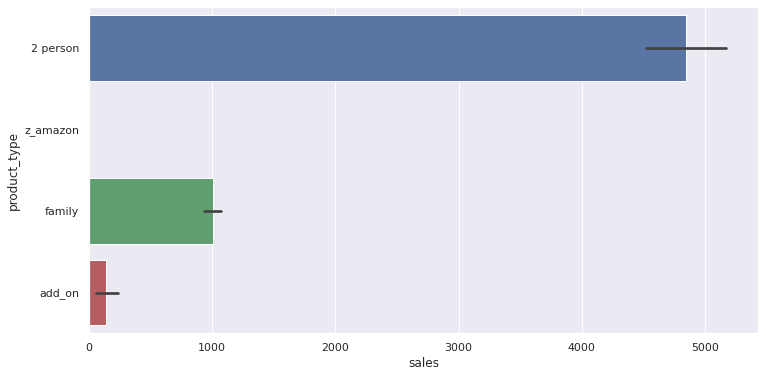

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


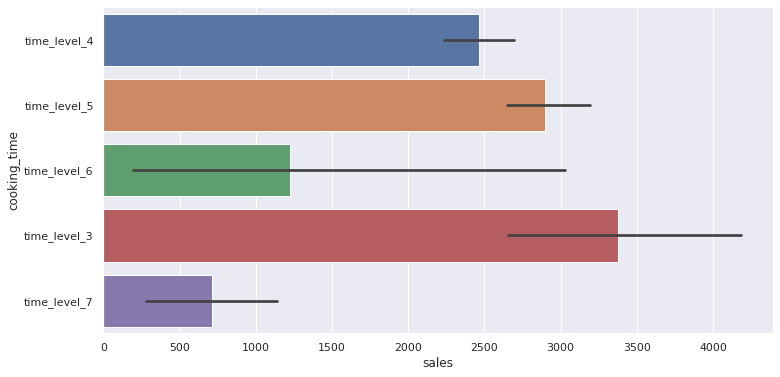

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


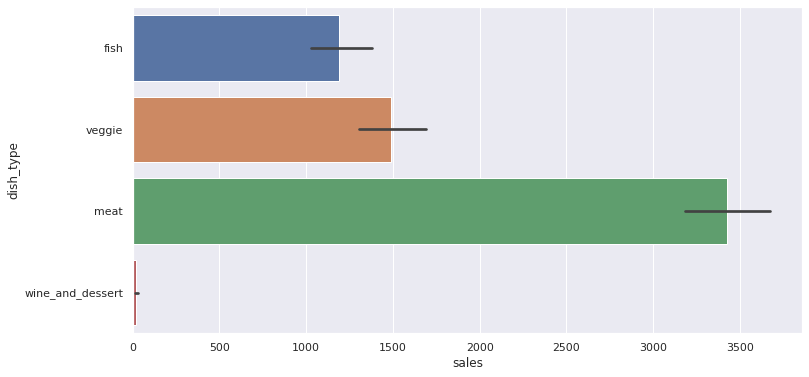

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


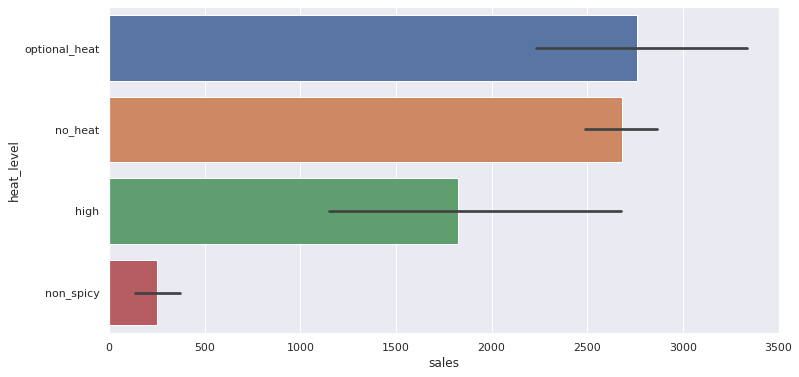

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


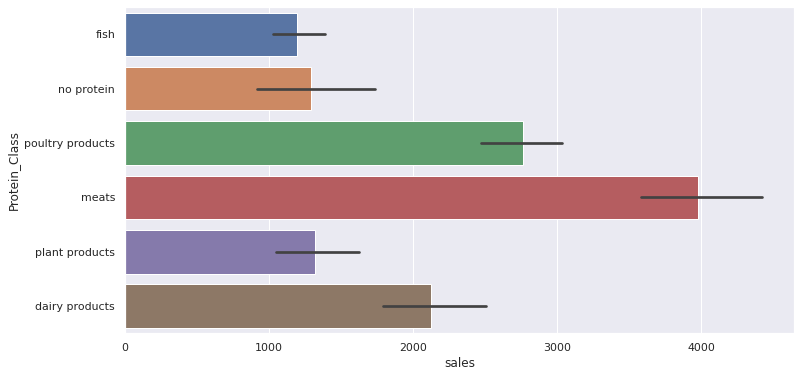

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


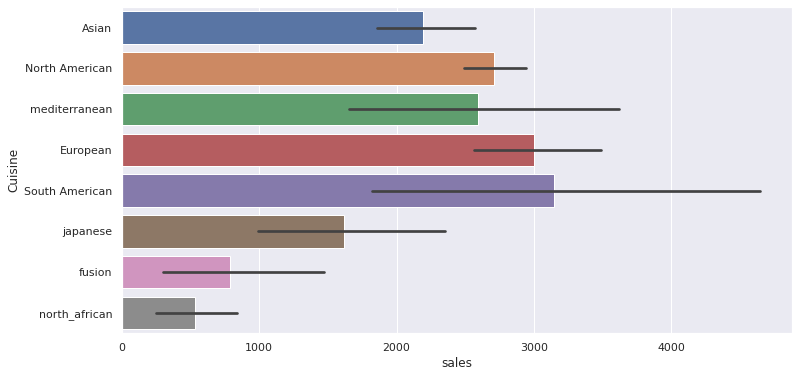

In [ ]:
#Creating a new list containing name of columns of categorical objects.
ncategoricalCols = [x for x in FullTable.columns if FullTable[x].dtypes == 'object']
nTargetVar = ['sales']
nnumericalCols =  [x for x in FullTable.columns if x not in categoricalCols + TargetVar]
for i in ncategoricalCols:
  barPlot(i)

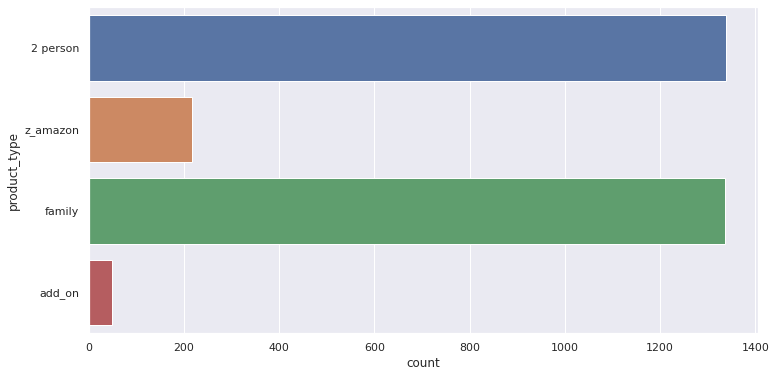

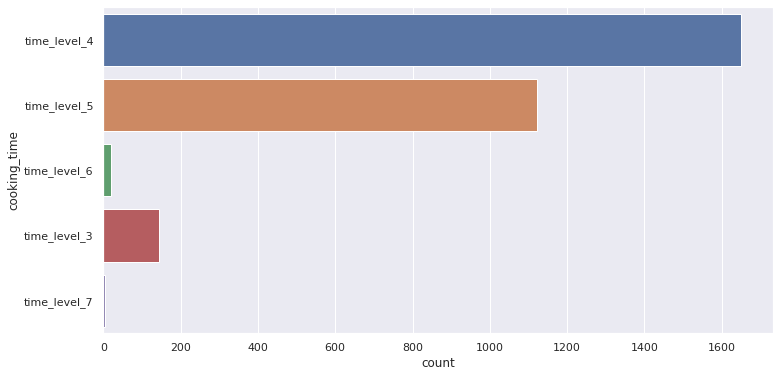

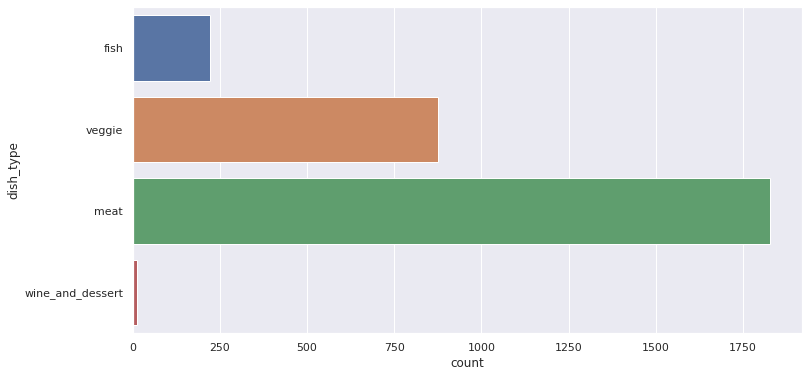

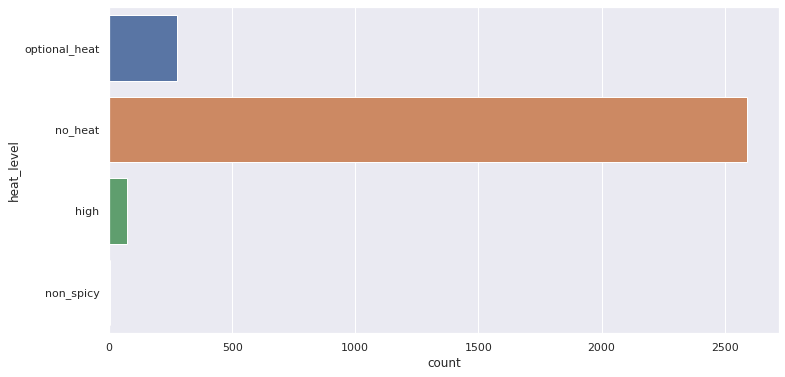

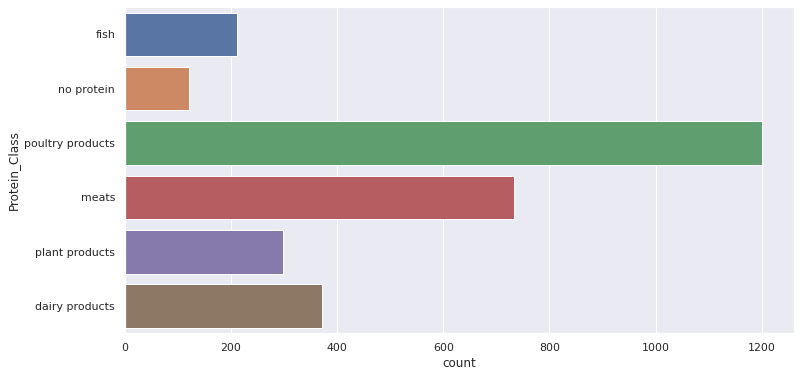

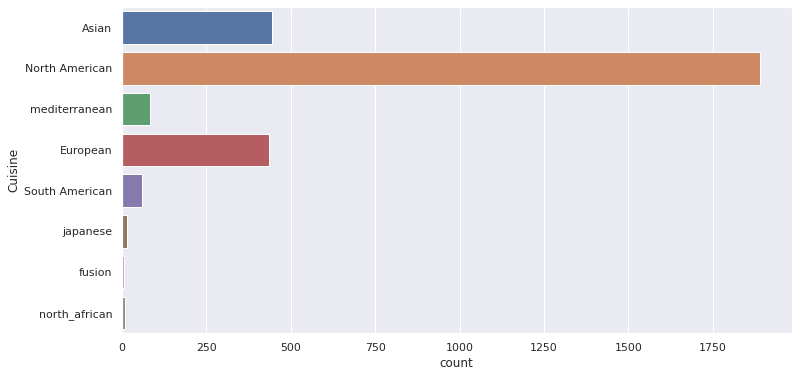

In [ ]:
def countPlot(column):
    '''
    column takes the value of the current column feature which is used to plot against the sales column.
    '''
    fig = plt.figure(figsize = (12,6))
    sns.countplot(y = column, data=FullTable)
    plt.show()
  
for i in ncategoricalCols:
  countPlot(i)

In [ ]:
#time)level_ and time_level_7 data points are extremely low and will create room for bisaement
heat = ['time_level_6', 'time_level_7']
for i in heat:
  FullTable.drop(axis=0, index = list(FullTable[FullTable['cooking_time'] == i].index), inplace=True)

#non_spicy data point is extremely low and will create room for bisaement
FullTable.drop(axis=0, index = list(FullTable[FullTable['heat_level']== 'non_spicy'].index), inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
FullTable.to_csv('final_restaurant.csv', index=False)

Data Cleaning Technicque

Strip out columns containing more than 30% missing values of the total dataset
Strip out columns containing too many outliers
Strip out columns not enough to determine the sales return. 

In [ ]:
target = ['sales']
num_col = [x for x in testTab.columns if testTab[x].dtypes != 'object' and x not in target]

## Outliers Removal

In [ ]:
#Using Standard Deviation Method
data = pd.read_csv('final_restaurant.csv')
meanD, stD = np.mean(data['sales']), np.std(data['sales'])

cutoff = stD * 3

lower, upper = meanD - cutoff, meanD + cutoff

In [ ]:
outliers = [y for y, x in enumerate(data['sales']) if x < lower or x > upper]

In [ ]:
data.drop(outliers, inplace=True)

In [ ]:
data.describe()

,calories,carbs,fat,number_of_ingredients_per_recipe,proteins,sales
count,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000
mean,726.017382,65.595753,37.866199,7.071888,34.461167,1967.804721
std,170.618688,31.031169,29.181896,1.831600,11.964164,3341.127049
min,0.000000,3.000000,5.000000,0.000000,1.500000,3.000000
25%,610.000000,46.900000,27.000000,6.000000,26.000000,257.000000
50%,720.000000,64.969046,36.000000,7.000000,34.841110,766.500000
75%,834.000000,83.625000,44.925000,9.000000,43.000000,2094.500000
max,1380.000000,880.000000,664.000000,11.000000,94.000000,16969.000000


# Required buttons and data by software engineering team

In [ ]:
#Creating a list containing name of columns of new categorical objects and new numerical.
ncategoricalCols = [x for x in data.columns if data[x].dtypes == 'object']
nTargetVar = ['sales']
nnumericalCols =  [x for x in data.columns if x not in ncategoricalCols + nTargetVar]

In [ ]:
X = data.drop('sales', 1).reset_index(drop=True)
y = data['sales'].reset_index(drop=True)

In [ ]:
X = np.array(X)
y = np.log(y)

In [ ]:
for i in ncategoricalCols:
  print(i, data[i].unique())

product_type ['2 person' 'z_amazon' 'family' 'add_on']
cooking_time ['time_level_4' 'time_level_5' 'time_level_3']
dish_type ['fish' 'veggie' 'meat' 'wine_and_dessert']
heat_level ['optional_heat' 'no_heat' 'high']
Protein_Class ['fish' 'no protein' 'poultry products' 'meats' 'plant products'
 'dairy products']
Cuisine ['Asian' 'North American' 'mediterranean' 'European' 'South American'
 'japanese' 'fusion' 'north_african']


In [ ]:
for i in nnumericalCols:
  print(i, min(data[i]), max(data[i]))

calories 0.0 1380.0
carbs 3.0 880.0
fat 5.0 664.0
number_of_ingredients_per_recipe 0 11
proteins 1.5 94.0


In [ ]:
pd.DataFrame({
    "Name":["Product Type", "cooking Time", "Dish Type", "Heat Level", "Protein Class", "Cuisine", "Calories", "Carbs", "Fat", "Nos of Ingredients/Recipe", "Proteins"],
    "FieldType": ["Dropdown list","Dropdown list","Dropdown list","Dropdown list","Dropdown list","Dropdown list", "Inputfield", "Inputfield", "Inputfield", "Inputfield", "Inputfield" ],
    "VarChar" : ["Strings","Strings","Strings","Strings","Strings","Strings","float", "float", "float", "int64", "float"],
    "Values/Options" : ["2 person, z_amazon, family, add_on","'time_level_4, time_level_5, time_level_3", "fish, veggie, meat, wine_and_dessert", "optional_heat, no_heat, high", "fish, no protein, poultry products, meats, plant products, dairy products", "Asian, North American, mediterranean, European, South American, japanese, fusion, north_african", "0.0 - 999.0", "0.0 - 999.0", "0.0 - 999.0", "0 - 999", "0.0 - 999.0"],
}).to_csv('datapoints.csv', index=False)

# Model Development

In [ ]:
pip install catboost

     |████████████████████████████████| 65.8MB 60kB/s 


In [ ]:
import catboost 
from catboost import CatBoostRegressor, Pool
import sklearn 
from sklearn.model_selection import train_test_split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
cat_features = [0, 3, 4, 5, 9, 10]
pool = Pool(data=X_train,
            label=y_train,
            cat_features=cat_features)

In [ ]:
model = CatBoostRegressor(iterations=80,
                          depth=6,
                          learning_rate=0.1,
                          random_state=1,
                          loss_function='RMSE',
                          eval_metric= 'R2')

In [ ]:
model.fit(pool, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1153735	test: 0.1204684	best: 0.1204684 (0)	total: 59.1ms	remaining: 4.67s
1:	learn: 0.2116206	test: 0.2198834	best: 0.2198834 (1)	total: 69.6ms	remaining: 2.71s
2:	learn: 0.2861505	test: 0.3001440	best: 0.3001440 (2)	total: 76.2ms	remaining: 1.96s
3:	learn: 0.3519421	test: 0.3680785	best: 0.3680785 (3)	total: 83.5ms	remaining: 1.59s
4:	learn: 0.4053734	test: 0.4256006	best: 0.4256006 (4)	total: 85.3ms	remaining: 1.28s
5:	learn: 0.4565710	test: 0.4761127	best: 0.4761127 (5)	total: 91.8ms	remaining: 1.13s
6:	learn: 0.4963502	test: 0.5160091	best: 0.5160091 (6)	total: 98.4ms	remaining: 1.03s
7:	learn: 0.5241562	test: 0.5443887	best: 0.5443887 (7)	total: 104ms	remaining: 934ms
8:	learn: 0.5538409	test: 0.5742886	best: 0.5742886 (8)	total: 113ms	remaining: 892ms
9:	learn: 0.5770088	test: 0.5980565	best: 0.5980565 (9)	total: 123ms	remaining: 860ms
10:	learn: 0.5958572	test: 0.6172740	best: 0.6172740 (10)	total: 132ms	remaining: 829ms
11:	learn: 0.6060095	test: 0.6286103	best: 0.

In [ ]:
pred = np.exp(model.predict(X_test))

In [ ]:
for i in range(50):
  print("Predicted: ", pred[i], "Actual:", list(np.exp(y_test))[i])


Predicted:  1123.8263755475136 Actual: 636.9999999999999
Predicted:  729.2788323144079 Actual: 463.0
Predicted:  669.5477429482831 Actual: 601.9999999999999
Predicted:  2717.2753606518845 Actual: 21277.99999999998
Predicted:  2185.98493147195 Actual: 773.0000000000003
Predicted:  3373.652324411311 Actual: 813.9999999999998
Predicted:  263.17948686543156 Actual: 404.00000000000017
Predicted:  955.9227160145775 Actual: 270.00000000000006
Predicted:  725.6465328030478 Actual: 2245.9999999999995
Predicted:  4.971957504251862 Actual: 4.0
Predicted:  2080.165961629575 Actual: 2369.0
Predicted:  2226.0720244461186 Actual: 2941.0000000000014
Predicted:  4.971957504251862 Actual: 6.0
Predicted:  733.8320059488666 Actual: 154.00000000000006
Predicted:  7.224092799651223 Actual: 6.0
Predicted:  768.5207496820959 Actual: 329.99999999999994
Predicted:  788.2811203483731 Actual: 1956.9999999999998
Predicted:  1928.06190469128 Actual: 726.9999999999999
Predicted:  677.8411071684073 Actual: 4378.99999

In [ ]:
joblib.dump(model, 'myModel.sav')

['myModel.sav']

In [ ]:
mod = joblib.load('myModel.sav')

In [ ]:
ans = mod.predict(['2 Person', 834.0, 110.4, 'time_level_4', 'meat', 'no_heat', 15.9,
                    10, 57.4, 'poultry products', 'North American'])

print(np.exp(ans))

95.71308189626441


In [ ]:
np.exp(mod.predict(X_test[800]))

3760.7575712115467

In [ ]:
X_test[800]

array(['2 person', 700.0, 47.0, 'time_level_4', 'meat', 'high', 43.0, 6,
       35.0, 'meats', 'North American'], dtype=object)

In [ ]:
np.exp(y_test[800])

14260.99999999999

In [ ]:
pd.DataFrame({
    "Name":["Product Type", "cooking Time", "Dish Type", "Heat Level", "Protein Class", "Cuisine", "Calories", "Carbs", "Fat", "Nos of Ingredients/Recipe", "Proteins"],
    "FieldType": ["Dropdown list","Dropdown list","Dropdown list","Dropdown list","Dropdown list","Dropdown list", "Inputfield", "Inputfield", "Inputfield", "Inputfield", "Inputfield" ],
    "VarChar" : ["Strings","Strings","Strings","Strings","Strings","Strings","float", "float", "float", "int64", "float"],
    "Values/Options" : ["2 person, z_amazon, family, add_on","'time_level_4, time_level_5, time_level_3", "fish, veggie, meat, wine_and_dessert", "optional_heat, no_heat, high", "fish, no protein, poultry products, meats, plant products, dairy products", "Asian, North American, mediterranean, European, South American, japanese, fusion, north_african", "0.0 - 999.0", "0.0 - 999.0", "0.0 - 999.0", "0 - 999", "0.0 - 999.0"],
}).to_csv('datapoints.csv', index=False)

In [ ]:
import pandas as pd 
data = pd.read_csv('final_restaurant.csv')
data.head()

,product_type,calories,carbs,cooking_time,dish_type,heat_level,fat,number_of_ingredients_per_recipe,proteins,sales,Protein_Class,Cuisine
0,2 person,687.0,99.2,time_level_4,fish,optional_heat,18.6,7,29.5,3567,fish,Asian
1,2 person,779.0,81.3,time_level_4,veggie,no_heat,38.5,5,30.0,2532,no protein,North American
2,z_amazon,642.0,92.8,time_level_4,veggie,no_heat,25.6,10,16.2,6,poultry products,North American
3,family,620.0,93.2,time_level_4,fish,optional_heat,13.7,7,28.7,642,fish,Asian
4,family,610.0,67.0,time_level_4,meat,no_heat,20.0,7,36.0,1492,poultry products,North American
